In [5]:
### Load PPS model
%run ./PPS_model_auditory.ipynb
ia_0 = 2.5
it_0 = 2.5

In [6]:
def Fw (Wt_0,Wa_0,Bt_0,Ba_0,k1,k2,lim,alpha):
    #k1 = 10
    #k2 = 700
    #alpha = 0.9

    # Tactile connections
    Bt = np.ones((Mt,Nt))*Bt_0
    Wt = np.ones((Mt,Nt))*Wt_0

    # Visual connections
    Ba = np.zeros((Ma,Na))
    Wa = np.zeros((Ma,Na))

    #lim = 20

    for i in range(Ma):
        for j in range(Na):
            if (xa[i]<lim):
                D = 0
            else: 
                D = distance.euclidean((xa[i],ya[j]),(lim,ya[j]))              
            Ba[i,j] = alpha*Ba_0*np.exp(- D/k1)+(1-alpha)*Ba_0*np.exp(- D/k2)
            Wa[i,j] = alpha*Wa_0*np.exp(- D/k1)+(1-alpha)*Wa_0*np.exp(- D/k2)
    return Wt,Wa,Bt,Ba

## Feedback inputs

# Tactile area
def bt(z,Bt):
    bt = np.multiply(Bt,z)
    return bt

# Auditory area
def ba(z,Ba):
    ba = np.multiply(Ba,z)
    return ba

In [7]:
## Experiment Function

def boundaryexperimentrun(a_distances,time,b,pr,k1,k2,lim,alpha):
    Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5,k1,k2,lim,alpha)
    dt = 0.4
    timesteps = int(time/dt)
    ndist = len(a_distances)
    
    RTs = np.zeros(ndist)
    ZTs = np.zeros((Mt,Nt,ndist))
    ZAs = np.zeros((Ma,Na,ndist))
    
    ti = PHIt(0) 
    PrBa = prun(Ba,pr)
    PrWa = prun(Wa,pr*2.6)
    dtau = dt/tau
    
    qt = np.zeros((Mt,Nt,timesteps+1,ndist))
    ut = np.zeros((Mt,Nt,timesteps+1,ndist))
    zt = np.zeros((Mt,Nt,timesteps+1,ndist))
    pt = np.zeros((Mt,Nt,timesteps+1,ndist))

    qa = np.zeros((Ma,Na,timesteps+1,ndist))
    ua = np.zeros((Ma,Na,timesteps+1,ndist))
    za = np.zeros((Ma,Na,timesteps+1,ndist))
    pa = np.zeros((Ma,Na,timesteps+1,ndist))

    qm = np.zeros((timesteps+1,ndist))
    um = np.zeros((timesteps+1,ndist))
    zm = np.zeros((timesteps+1,ndist))
    pm = np.zeros((timesteps+1,ndist))
    
    rt = np.zeros((timesteps+1,ndist))
    
    for d in range(ndist):
        xa_0 = a_distances[d] # How far the sound is presented.     
        ai = PHIa(0,xa_0) # Generates an auditory input

        for i in range(timesteps):    
            # Tactile activity
            ut[:,:,i+1,d] = ti+LIt(zt[:,:,i,d])+bt(zm[i,d],Bt)
            qt[:,:,i+1,d] = qt[:,:,i,d] + dtau*(-qt[:,:,i,d]+ut[:,:,i,d])
            pt[:,:,i+1,d] = psit(qt[:,:,i,d],b)
            zt[:,:,i+1,d] = pt[:,:,i,d]*np.heaviside(pt[:,:,i,d],0)

            # Auditory activity
            ua[:,:,i+1,d] = ai+LIa(za[:,:,i,d])+ba(zm[i,d],PrBa) 
            qa[:,:,i+1,d] = qa[:,:,i,d] + dtau*(-qa[:,:,i,d]+ua[:,:,i,d])
            pa[:,:,i+1,d] = psia(qa[:,:,i,d],b)
            za[:,:,i+1,d] = pa[:,:,i,d]*np.heaviside(pa[:,:,i,d],0)

            # Multisensory activity
            um[i+1,d] = np.sum(np.multiply(Wt,zt[:,:,i,d])) + np.sum(np.multiply(PrWa,za[:,:,i,d]))
            qm[i+1,d] = qm[i,d] + dtau*(-qm[i,d]+um[i,d])
            pm[i+1,d] = psim(qm[i,d])
            zm[i+1,d] = pm[i,d]*np.heaviside(pm[i,d],0)
            
            # Response
            rt[i+1,d] = np.any(zt[:,:,i,d]>(0.9*ft_max))
            
        RTs[d] = np.argmax(rt[:,d])*dt
        ZMs = zm        
        ZTs[:,:,d] = zt[:,:,timesteps,d]
        ZAs[:,:,d] = za[:,:,timesteps,d]   
    return RTs,ZMs,ZTs,ZAs

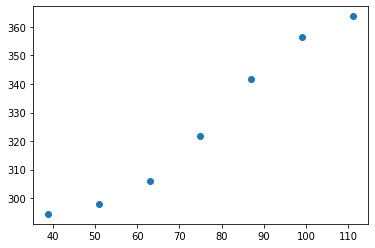

In [8]:
### Audio-tactile experiment simulation setup 

## Calculate distance in cms. Speaker is positioned at 100cm from the hand. 
s_distances = np.asarray([2700,2200,1500,800,300])/1000
#s_distances = np.asarray([300,800,1500,2200,2700])/1000
ts = np.linspace(s_distances[0],s_distances[-1],7)
v = 30 #cm/s 
a_distances = (120 - ts*v) # distance points in cm (network coordinates)

## Simulation setup
simtime = 100 #ms 

## Synapses setup
Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,1,4)
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5,10,700,60,0.9) 
bi = 0
pr = 0

# Experimental Data
ymin = 292.67682496787893
ymax = 368.14828117144293 
cp = 120-1.329*v
slope = 11.11111111111111
HC_RTs = RTsig(a_distances,cp,slope)
plt.scatter(a_distances,HC_RTs)

In [9]:
def boundaryhcmodelrun(theta):
    hcRTs,ZMs,ZTs,ZAs = boundaryexperimentrun(a_distances,simtime,bi,pr,theta[0],theta[1],theta[2],theta[3])
    xf = hcRTs
    yf = HC_RTs
    
    m = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
    bias = (np.sum(yf) - m*np.sum(xf)) / xf.size    
    
    if bias<0: bias=0
    if m<0: m=0
    
    cost = np.sum(np.square(np.divide(yf-(m*xf+bias),yf)))

    return cost

bounds=[(1,50),(500,1000),(20,80),(0.25,1)]
boundaryhcres = differential_evolution(boundaryhcmodelrun,bounds,disp=True)

differential_evolution step 1: f(x)= 0.000230218
differential_evolution step 2: f(x)= 0.000177587
differential_evolution step 3: f(x)= 0.000158192
differential_evolution step 4: f(x)= 0.000119335
differential_evolution step 5: f(x)= 0.000101427
differential_evolution step 6: f(x)= 0.000101427
differential_evolution step 7: f(x)= 8.52757e-05
differential_evolution step 8: f(x)= 8.52757e-05
differential_evolution step 9: f(x)= 8.52757e-05
differential_evolution step 10: f(x)= 8.52757e-05
differential_evolution step 11: f(x)= 7.52966e-05
differential_evolution step 12: f(x)= 6.41547e-05
differential_evolution step 13: f(x)= 6.41547e-05
differential_evolution step 14: f(x)= 6.41547e-05
differential_evolution step 15: f(x)= 6.41547e-05
differential_evolution step 16: f(x)= 6.41547e-05
differential_evolution step 17: f(x)= 6.41547e-05
differential_evolution step 18: f(x)= 6.41547e-05
differential_evolution step 19: f(x)= 6.41547e-05
differential_evolution step 20: f(x)= 6.41547e-05
different

In [10]:
print(boundaryhcres)

     fun: 5.854088446638357e-05
 message: 'Optimization terminated successfully.'
    nfev: 5225
     nit: 86
 success: True
       x: array([ 21.55478036, 688.70848466,  53.43378121,   0.99251631])


In [11]:
hcRTs,ZMs,ZTs,ZAs = boundaryexperimentrun(a_distances,simtime,0,0,21.55478036, 688.70848466,  53.43378121,   0.99251631)

3.326543108904351 87.63605187144955


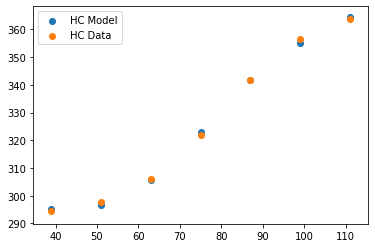

In [12]:
xf = hcRTs
yf = HC_RTs
m = (xf.size * np.sum(xf*yf) - np.sum(xf) * np.sum(yf)) / (xf.size*np.sum(xf*xf) - np.sum(xf) ** 2)
bias = (np.sum(yf) - m*np.sum(xf)) / xf.size

plt.figure(1)
plt.scatter(a_distances,m*hcRTs+bias,label = 'HC Model')
plt.scatter(a_distances,yf,label = 'HC Data')
plt.legend()
print(m,bias)

In [11]:
sczbaseline = np.asarray([m*xf+bias,yf])
np.save('sczbaselinecopy.npy', sczbaseline)

In [12]:
print(hcRTs)
print(m,bias)

[70.4 67.6 62.8 59.2 57.2]
5.14942787941318 1.288990823894983
